In [1]:
import pandas as pd
import numpy as np
import os
import math

from pathlib import Path
import pickle
import sys
import joblib
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error,explained_variance_score

# preproceessing
from model_transformers2 import FeaturesInteractions,SkewTransformer,ZeroThreshold
from stacking_models import StackingAveragedModels,AveragingModels

import seaborn as sns

#from mlxtend.plotting import plot_linear_regression
%matplotlib inline


In [2]:
# Test data 
adapt_final = pd.read_csv('../data/ADAPT_3bdy_Test15.csv',index_col=0)

In [3]:
# X and y data transformed to delta G
X = adapt_final.drop(["z-score","ddG_exp"],axis=1)

In [4]:
X.columns.shape

(77,)

In [5]:
# lasso_model = joblib.load('Lasso_train15skempiAB_FINAL.pkl')
# #elasticnet_model = joblib.load('elasticNet_train15skempiAB_FINAL.pkl')
# svr_model = joblib.load('rbfSVRmodel_train15skempiAB_FINAL.pkl')
# poly_model = joblib.load("poly2SVRmodel_train15skempiAB_FINAL.pkl")
# gbt_model = joblib.load('GBTmodel_train15skempiAB_FINAL.overf.pkl')

stackedModel = joblib.load('stacked_averaged_models_FINAL.3b1mSVRp.pkl')
avgModel = joblib.load('avg_models_FINAL.3m.pkl')

In [6]:
# lasso_pred = lasso_model.predict(X)
# #elasticnet_pred = elasticnet_model.predict(X)
# svr_pred = svr_model.predict(X)
# poly_pred = poly_model.predict(X)
# gbt_pred = gbt_model.predict(X)
stacked_pred = stackedModel.predict(X.values)
avgModel_pred = avgModel.predict(X.values)

In [7]:
pred_stack = np.hstack([adapt_final[["z-score","ddG_exp"]].values,
                        stacked_pred.reshape((-1,1)),avgModel_pred.reshape((-1,1))])
pred_data = pd.DataFrame(pred_stack,columns=["z-score","ddG_exp","stacked_pred","avgModel_pred"],index=X.index)


In [8]:
# pred_stack = np.hstack([adapt_final[["z-score","ddG_exp"]].values,
#                         lasso_pred.reshape((-1,1)),gbt_pred.reshape((-1,1)),svr_pred.reshape((-1,1)),
#                         poly_pred.reshape((-1,1)),stacked_pred.reshape((-1,1)),avgModel_pred.reshape((-1,1))])
# pred_data = pd.DataFrame(pred_stack,columns=["z-score","ddG_exp","Lasso_pred","gbt_pred","svr_pred",
#                                              "poly_pred","stacked_pred","avgModel_pred"],index=X.index)
# pred_data["mean-pred"] = pred_data.loc[:,["Lasso_pred","gbt_pred","svr_pred","poly_pred"]].mean(axis=1)

In [9]:
pred_data_notna = pred_data.dropna(axis=0)

In [10]:
pred_data_notna

,z-score,ddG_exp,stacked_pred,avgModel_pred
3bdy.protein.H33M.Repair4.clean.pdb,-1.8,0.03,0.241337,0.629289
3bdy.protein.H33W.Repair4.clean.pdb,-2.4,-0.09,-0.053429,0.157784
3bdy.protein.H52R.Repair4.clean.pdb,-2.4,0.30,0.114432,0.530106
3bdy.protein.H98F.Repair4.clean.pdb,-6.8,-1.18,0.024310,0.229783
3bdy.protein.H98H.Repair4.clean.pdb,-4.3,-0.62,-0.087514,0.097520
3bdy.protein.H98K.Repair4.clean.pdb,-4.1,-0.63,0.016442,0.312421
3bdy.protein.H98M.Repair4.clean.pdb,-6.5,-1.33,-0.243400,-0.083868
3bdy.protein.H98W.Repair4.clean.pdb,-8.5,-1.23,-0.566572,-0.609739
3bdy.protein.H98Y.Repair4.clean.pdb,-6.4,-0.76,-0.258892,-0.287946
3bdy.protein.H99D.Repair4.clean.pdb,-1.6,-0.48,-0.093160,0.381779


In [14]:
explained_variance_score(pred_data_notna["ddG_exp"],pred_data_notna["stacked_pred"])

0.3010147307462996

In [133]:
explained_variance_score??

In [258]:
explained_variance_score(pred_data_notna["ddG_exp"],pred_data_notna["avgModel_pred"])

0.47591832998972994

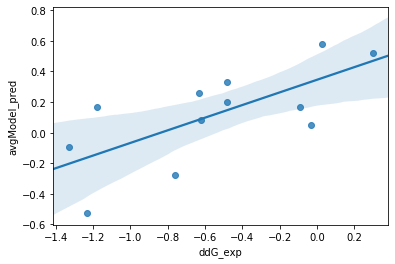

In [243]:
sns.regplot(pred_data_notna["ddG_exp"],pred_data_notna["avgModel_pred"])

In [121]:
mcsm_result = pd.read_table("../data/3bdy_mcsm_results.txt")


In [122]:
with open("../data/3bdy.pdb.beat.txt","r") as f:
    lines = f.readlines()
    ddg_values = [float(list(filter(lambda name: name.strip(), l.split(" ")))[7]) for l in lines ]
    chain =  [list(filter(lambda name: name.strip(), l.split(" ")))[2] for l in lines ]
    mut_res = [list(filter(lambda name: name.strip(), l.split(" ")))[5] for l in lines ]
    num_res = [list(filter(lambda name: name.strip(), l.split(" ")))[3] for l in lines ]
    
    mutant = list(map("".join, zip(chain, num_res,mut_res)))
    
    pd_beatmusic = pd.DataFrame({"mutant":mutant,"beat_pred":ddg_values})
    
    

In [124]:
mcsm_result["mutant"]= mcsm_result["CHAIN"].astype(str)+mcsm_result["RES_POS"].astype(str)+mcsm_result["MUT_RES"].astype(str)
mcsm_result = mcsm_result[["PRED_DDG","mutant"]]
#merge data on mutant column
pred_data_notna["mutant"] = pred_data_notna.reset_index()["index"].str.split(".",expand=True)[2].values

/home/vfica/miniconda3/envs/abpred/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [125]:
pred_data_final = pred_data_notna.merge(mcsm_result,on="mutant").merge(pd_beatmusic,on="mutant")
pred_data_final.set_index("mutant",inplace=True)
pred_data_final

,z-score,ddG_exp,stacked_pred,avgModel_pred,PRED_DDG,beat_pred
mutant,,,,,,
H33M,-1.8,0.03,0.241337,0.629289,0.597,1.16
H33W,-2.4,-0.09,-0.053429,0.157784,1.220,0.62
H52R,-2.4,0.30,0.114432,0.530106,-0.280,0.79
H98F,-6.8,-1.18,0.024310,0.229783,0.281,0.22
H98H,-4.3,-0.62,-0.087514,0.097520,-1.387,0.12
H98K,-4.1,-0.63,0.016442,0.312421,-0.299,0.09
H98M,-6.5,-1.33,-0.243400,-0.083868,-0.921,0.19
H98W,-8.5,-1.23,-0.566572,-0.609739,0.480,0.18
H98Y,-6.4,-0.76,-0.258892,-0.287946,0.265,0.22


In [115]:
explained_variance_score(pred_data_final["ddG_exp"],pred_data_final["stacked_pred"])

0.3010147307462996

In [127]:
explained_variance_score(pred_data_final["ddG_exp"],pred_data_final["beat_pred"])

0.42353209168121997

In [132]:
explained_variance_score(pred_data_final["ddG_exp"],pred_data_final["PRED_DDG"])

-1.9366376682684487

In [105]:
np.sqrt(pred_data_final.apply(mean_squared_error,axis=0,args=(pred_data_final["ddG_exp"],)))

z-score          4.531425
ddG_exp          0.000000
stacked_pred     0.614016
avgModel_pred    0.781500
PRED_DDG         1.221904
beat_pred        0.984717
dtype: float64

In [129]:
pred_data_final.corr()

,z-score,ddG_exp,stacked_pred,avgModel_pred,PRED_DDG,beat_pred
z-score,1.000000,0.632829,0.758662,0.781332,0.273251,0.467480
ddG_exp,0.632829,1.000000,0.577063,0.670109,0.304147,0.651116
stacked_pred,0.758662,0.577063,1.000000,0.941091,0.013487,0.500307
avgModel_pred,0.781332,0.670109,0.941091,1.000000,0.137013,0.547501
PRED_DDG,0.273251,0.304147,0.013487,0.137013,1.000000,0.209852
beat_pred,0.467480,0.651116,0.500307,0.547501,0.209852,1.000000


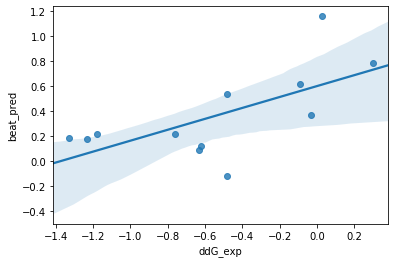

In [97]:
sns.regplot(pred_data_final["ddG_exp"],pred_data_final["beat_pred"])